Số lượng giá trị thiếu ban đầu:
 Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64
Sentiment
1    17448
0     2370
Name: count, dtype: int64


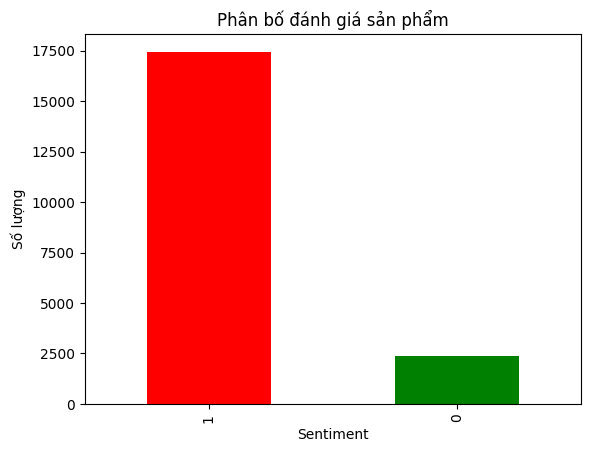

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.920787083753784
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       478
           1       0.96      0.95      0.95      3486

    accuracy                           0.92      3964
   macro avg       0.81      0.82      0.81      3964
weighted avg       0.92      0.92      0.92      3964



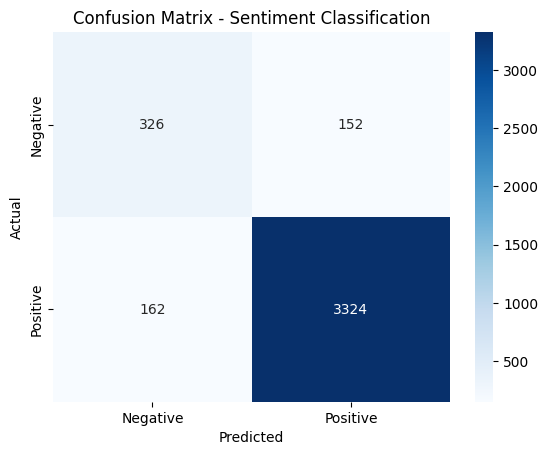

Review: This dress is fantastic! I love it! -> Sentiment: Positive
Review: The fabric is terrible and it ripped easily. -> Sentiment: Negative
Review: I am very satisfied with this purchase, great quality! -> Sentiment: Positive
Review: Poorly made, not worth the money. -> Sentiment: Negative
Review: Absolutely love this! Fits perfectly. -> Sentiment: Positive
Review: Not happy at all, bad experience. -> Sentiment: Positive
Review: Wonderful fabric and excellent design! -> Sentiment: Positive
Review: Size was incorrect and material feels cheap. -> Sentiment: Negative


['random_tfidf_vectorizer.pkl']

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.ensemble import BalancedRandomForestClassifier
import joblib
# Tải dữ liệu
file_path = "Womens Clothing E-Commerce Reviews.csv"
df = pd.read_csv(file_path)

# Loại bỏ dữ liệu thiếu
print("Số lượng giá trị thiếu ban đầu:\n", df.isnull().sum())
df = df.dropna(subset=['Review Text', 'Rating'])

# Đánh nhãn dữ liệu
df = df[df['Rating'] != 3]
df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x > 3 else 0)
print(df['Sentiment'].value_counts())

# Vẽ đồ thị phân bố
df['Sentiment'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.xlabel("Sentiment")
plt.ylabel("Số lượng")
plt.title("Phân bố đánh giá sản phẩm")
plt.show()

# Tiền xử lý văn bản
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

df['Cleaned Review'] = df['Review Text'].apply(clean_text)

# Biểu diễn văn bản bằng TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Cleaned Review'])
y = df['Sentiment'].values

# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = BalancedRandomForestClassifier(
    n_estimators=200,
    sampling_strategy=0.5,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Đánh giá mô hình
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Sentiment Classification")
plt.show()

# Dự đoán với dữ liệu mới
new_reviews = [
    "This dress is fantastic! I love it!",
    "The fabric is terrible and it ripped easily.",
    "I am very satisfied with this purchase, great quality!",
    "Poorly made, not worth the money.",
    "Absolutely love this! Fits perfectly.",
    "Not happy at all, bad experience.",
    "Wonderful fabric and excellent design!",
    "Size was incorrect and material feels cheap."
]
new_reviews_cleaned = [clean_text(text) for text in new_reviews]
new_reviews_vectorized = vectorizer.transform(new_reviews_cleaned)
predictions = model.predict(new_reviews_vectorized)
for review, pred in zip(new_reviews, predictions):
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"Review: {review} -> Sentiment: {sentiment}")
joblib.dump(model, 'randomforest.pkl')

# Lưu vectorizer
joblib.dump(vectorizer, 'random_tfidf_vectorizer.pkl')
